Deep Learning for text and sequences

In [0]:
# Word-level one-hot encoding
import numpy as np
samples = ['The cat sat on the mat.', 'The dog ate my homework.'] #Initial data: one entry per sample
token_index = {}# Builds an index of all tokens in the data
for sample in samples:
  for word in sample.split(): #tokenizes the samples via the splitmethod. 
    if word not in token_index:
      token_index[word] = len(token_index) + 1 #Assigns a unique index to each unique word. Note that you don’t attribute index 0 to anything.

In [0]:
max_length = 10 #Vectorizes the samples. You’ll only consider the first max_lengthwords in each sample.
results = np.zeros(shape=(len(samples),max_length,max(token_index.values()) + 1)) #storing results
for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = token_index.get(word)
    results[i, j, index] = 1

In [0]:
# Character-level one-hot encoding
import string
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable #All printable ASCIIcharacters
token_index = dict(zip(range(1, len(characters) + 1), characters))
max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
  for j, character in enumerate(sample):
    index = token_index.get(character)
    results[i, j, index] = 1

In [0]:
# Using Keras for word-level one-hot encoding
from keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000) #Creates a tokenizer, configured to only take into account the1,000 most common words
tokenizer.fit_on_texts(samples) # builds the word index
sequences = tokenizer.texts_to_sequences(samples)# Turns strings into lists of integer indices
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary') #You could also directly get the one-hot binary representations. Vectorization modes other than one-hot encoding are supported by this tokenizer
word_index = tokenizer.word_index #recovering the word index that was computed
print('Found %s unique tokens.' % len(word_index))


Using TensorFlow backend.


Found 9 unique tokens.


In [0]:
# Word-level one-hot encoding with hashing trick (toy example)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
#Stores the words as vectors of size 1,000. If you have close to 1,000 words (or more), you’ll see many hash collisions, which will decrease the accuracy of this encoding method
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = abs(hash(word)) % dimensionality #Hashes the word into a random integer index between 0 and 1,000
    results[i, j, index] = 1

The Embedding layer is best understood as a dictionary that maps integer indices(which stand for specific words) to dense vectors. It takes integers as input, it looks upthese integers in an internal dictionary, and it returns the associated vectors. It’s effec-tively a dictionary lookup

In [0]:
# Instantiating an Embedding layer
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
# The Embedding layer takes at least two arguments: the number of possible tokens (here, 1,000: 1 + maximum word index) and the dimensionality of the embeddings (here, 64) 

Let's try it out on IMDB movie-review sentiment-prediction task.

 

First, you'll quickly prepare the data. You'll restrict the movie reviews to the top 10,000 most common words and cut off the reviews after only 20 words. The network will learn 8-dimensional embeddings for each of the 10000 words, turn the input integer sequences (2D integer tensor) into embedding sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.

 

Loading the IMDB data for use with an Embedding layer

In [0]:
# Loading the IMDB data for use with an Embedding layer
from keras.datasets import imdb
from keras import preprocessing
max_features = 10000 # Number of words to consider as features
maxlen = 20 # Cuts off the text after this number of words (among the max_features most common words)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) #Loads the data as lists of integers
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen) #Turns the lists of integers intoa 2D integer tensor of shape(samples, maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
# Loading the IMDB data for use with an Embedding layer
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen)) # Specifies the maximum input length to the Embedding layer so you can later flatten the embedded inputs. 
# After the Embedding layer, the activations have shape (samples, maxlen, 8)
model.add(Flatten()) # Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8
model.add(Dense(1, activation='sigmoid')) # Adds the classifier on top
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_split=0.2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________



Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 2s 94us/step - loss: 0.6692 - acc: 0.6215 - val_loss: 0.6155 - val_acc: 0.6956
Epoch 2/10
20000/20000 [==============================] - 1s 68us/step - loss: 0.5360 - 

Downloading the IMDB data as raw text


First, head to http://mng.nz/0tIo and download the raw IMDB dataset. Uncompress it. Now, let's collect the individual training reviews into a list of strings, one string per review. You'll also collect the review labels (positive/negative) into a labels list.

In [79]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
import os

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/EVA/phase2/S1/aclImdb/aclImdb.zip", 'r')
zip_ref.extractall("/content/drive/My Drive/Colab Notebooks/EVA/phase2/S1/aclImdb/temp")
zip_ref.close()

In [0]:
# Processing the labels of the raw IMDB data
imdb_dir= '/content/gdrive/My Drive/Colab Notebooks/EVA/phase2/S1/aclImdb/temp/aclImdb/'

In [0]:
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt': 
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)


Tokenizing the data


In [62]:
# Tokenizing the text of the raw IMDB data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # cuts off reviews after 100 words
training_samples = 8000 # train only on 200 samples
validation_samples = 10000 # Validates on 10,000 samples
max_words = 10000 # Considers only the top 10,000 words in the datase
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Splits the data into a training set and a validation set, but first shuffles the data because you're starting with data in which samples are ordered, all negatives first, then all positives
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Download the Glove word embeddings

Go   to   https://nlp.stanford.edu/projects/glove,  and  download  the  precomputedembeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip,containing  100-dimensional  embedding  vectors  for  400,000  words  (or  nonwordtokens). Unzip it.





In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Parsing the GloVe word-embeddings file
# glove_dir
f = open('/content/gdrive/My Drive/Colab Notebooks/EVA/phase2/S1/glove/glovetemp/glove_6B_100d.txt')
embeddings_index = {}
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:],dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [66]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # Words not found in the embedding index will be all zeros

In [68]:
# model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Loading pretrained word embeddings into the Embedding lay
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [87]:
#training and evaluating
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 6s 765us/step - loss: 1.0996e-07 - acc: 1.0000 - val_loss: 0.9664 - val_acc: 0.8145
Epoch 2/10
8000/8000 [==============================] - 5s 657us/step - loss: 1.0990e-07 - acc: 1.0000 - val_loss: 0.9679 - val_acc: 0.8149
Epoch 3/10
8000/8000 [==============================] - 5s 665us/step - loss: 1.0981e-07 - acc: 1.0000 - val_loss: 0.9733 - val_acc: 0.8147
Epoch 4/10
8000/8000 [==============================] - 5s 662us/step - loss: 1.0978e-07 - acc: 1.0000 - val_loss: 0.9758 - val_acc: 0.8144
Epoch 5/10
8000/8000 [==============================] - 5s 653us/step - loss: 1.0977e-07 - acc: 1.0000 - val_loss: 0.9748 - val_acc: 0.8152
Epoch 6/10
8000/8000 [==============================] - 5s 670us/step - loss: 1.0973e-07 - acc: 1.0000 - val_loss: 0.9765 - val_acc: 0.8150
Epoch 7/10
8000/8000 [==============================] - 5s 653us/step - loss: 1.0976e-07 - acc: 1.0000 - val_lo

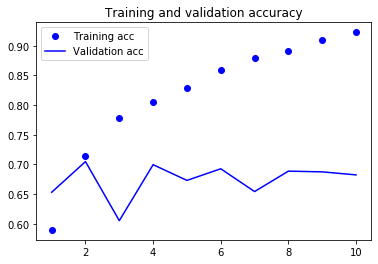

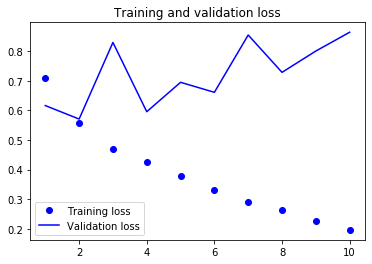

In [71]:
# plotting the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Training the same model without pretrained word embeddings

In [72]:

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 5s 657us/step - loss: 0.5482 - acc: 0.7086 - val_loss: 0.3818 - val_acc: 0.8324
Epoch 2/10
8000/8000 [==============================] - 5s 606us/step - loss: 0.1521 - acc: 0.9470 - val_loss: 0.4284 - val_acc: 0.8150
Epoch 3/10
8000/8000 [==============================] - 5s 657us/step - loss: 0.0128 - acc: 0.9976 - val_loss: 0.5410 - val_acc: 0.8192
Epoch 4/10
8000/8000 [==============================] - 5s 594us/step - loss: 5.0908e-04 - acc: 1.0000 - val_loss: 0.6762 - val_acc: 0.8147
Epoch 5/10
8000/8000 [==============================] - 5s 599us/step - loss: 1.0983e-05 - acc: 1.0000 - val_loss: 0.8176 - val_acc: 0.8172
Epoch 6/10
8000/8000 [==============================] - 5s 599us/step - loss: 4.6071e-07 - acc: 1.0000 - val_loss: 0.9122 - val_acc: 0.8142
Epoch 7/10
8000/8000 [==============================] - 5s 591us/step - loss: 1.1980e-07 - acc: 1.0000 - val_loss: 0.9384 -

In [0]:
# Tokenizing the data of the test set
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)
        
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [88]:
# Evaluating the model on the test set
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 62us/step


[0.9902084547122195, 0.81236]

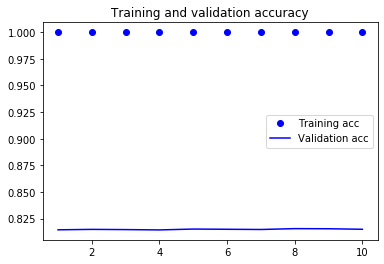

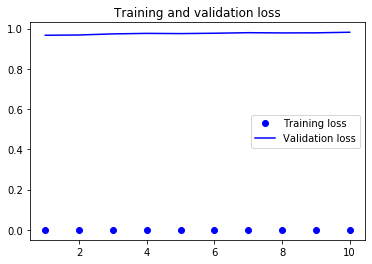

In [89]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()